Running simulation for alpha=0.0, a_i=0.5
Remaining Load: 94.72412998179117
[9]
Iteration: 0.15920715790251205, Newly Failed Nodes: [], Remaining Nodes: 98, Remaining Load: 94.72412998179117
Remaining Load: 92.71335259235153
[0]
Iteration: 0.5470414525398274, Newly Failed Nodes: [], Remaining Nodes: 97, Remaining Load: 92.71335259235153
Remaining Load: 99.49364371630075
[1]
Iteration: 0.5986553264777191, Newly Failed Nodes: [], Remaining Nodes: 96, Remaining Load: 99.49364371630075
Remaining Load: 98.73404058370781
[4]
Iteration: 0.6223506166695016, Newly Failed Nodes: [], Remaining Nodes: 95, Remaining Load: 98.73404058370781
Remaining Load: 94.90066982253806
[3]
Iteration: 0.7031741286549755, Newly Failed Nodes: [], Remaining Nodes: 94, Remaining Load: 94.90066982253806
Remaining Load: 94.64431721926525
[12]
Iteration: 0.9264122710633559, Newly Failed Nodes: [], Remaining Nodes: 93, Remaining Load: 94.64431721926525
Remaining Load: 99.32384029706931
[11]
Iteration: 1.6836863415390397

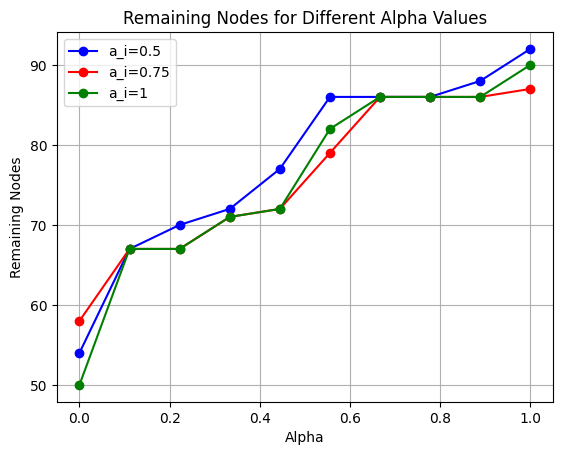

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import harmonic_mean

def initialize_load(graph, load, alpha):
    centrality = nx.degree_centrality(graph)  # Calculate centrality
    total_centrality = sum(centrality.values())
    for node in graph.nodes:
        if total_centrality != 0:
            node_load = centrality[node] * load / total_centrality  # Assign load based on centrality
        else:
            node_load = load / len(graph.nodes)  # Assign equal load if centrality sum is 0
        graph.nodes[node]['L'] = node_load  # Assign load to each node's 'L' attribute
        graph.nodes[node]['C'] = node_load * (1 + alpha)  # Capacity
        graph.nodes[node]['S'] = 0  # State initialization
    return graph

def update_state(graph, load, remove_nodes, t, alpha, a_i):
    newly_failed_nodes = []  # List to store newly failed nodes for the current iteration
    
    # Update state for nodes to be removed
    for node in remove_nodes:
        if graph.nodes[node]['S'] == 0:  # Check if node is active before marking as removed
            graph.nodes[node]['S'] = 1
            new_failures.append(node)  # Only add to new_failures if it's newly removed
    
    # Get subgraph of nodes with state 0
    state_0_nodes = [node for node, data in graph.nodes(data=True) if data['S'] == 0]
    subgraph = graph.subgraph(state_0_nodes)
    
    if state_0_nodes:  # Check if there are any active nodes left
        largest_cc = max(nx.connected_components(subgraph), key=len)
        # Calculate betweenness centrality on the original graph
        centrality = nx.betweenness_centrality(graph, weight='weight')
        total_centrality = sum(centrality.values())
        
        for v in largest_cc:
            graph.nodes[v]['L'] = centrality[v] * load / total_centrality  # Redistribute load
        
        for v in graph.nodes:
            if v not in largest_cc and graph.nodes[v]['S'] == 0:
                graph.nodes[v]['S'] = 2  # Mark nodes outside largest CC as failed
                newly_failed_nodes.append(v)  # Add to new_failures if it's a new failure
    else:
        # If no active nodes, mark remaining as failed
        for v in graph.nodes:
            if graph.nodes[v]['S'] == 0:
                graph.nodes[v]['S'] = 2
                newly_failed_nodes.append(v)  # Add to new_failures if it's a new failure
    
    return graph, newly_failed_nodes

def gillespie_step(graph, t, a_i, alpha):
    nodes_state_0 = [n for n, d in graph.nodes(data=True) if d['S'] == 0]
    lambda_values = [a_i * ((graph.nodes[n]['L'] - graph.nodes[n]['C']) / graph.nodes[n]['C']) for n in nodes_state_0 if graph.nodes[n]['L'] > graph.nodes[n]['C']]
    if not lambda_values:
        return float('inf'), graph, [], None  # Include None for chosen_node when no node is chosen
    cumulative_lambda_values = np.cumsum([0] + lambda_values)
    lambda_total = cumulative_lambda_values[-1]
    z1 = random.uniform(0, lambda_total)
    chosen_index = np.searchsorted(cumulative_lambda_values, z1) - 1  # Adjust index as we included 0 at start
    chosen_node = nodes_state_0[chosen_index]
    graph.nodes[chosen_node]['S'] = 1
    z2 = random.random()
    tau = -np.log(1 - z2) / lambda_total if lambda_total > 0 else float('inf')
    return tau, graph, [chosen_node], chosen_node  # Include chosen_node in the return values

def calculate_edge_impedance(graph, edge, a, b):
    node_i, node_j = edge
    degree_sum = graph.degree(node_i) + graph.degree(node_j)
    t_k_0 = 1 / degree_sum
    L_k_T = (graph.nodes[node_i]['L'] + graph.nodes[node_j]['L']) / 2
    C_k = (graph.nodes[node_i]['C'] + graph.nodes[node_j]['C']) / 2
    if C_k != 0:  # Avoid division by zero
        impedance = t_k_0 * (1 + a * (L_k_T / C_k)**b)
    else:
        impedance = float('inf')  # If capacity is zero, impedance is infinity

    return impedance

def calculate_node_impedance(graph, node):
    # Get edges connected to the node
    connected_edges = graph.edges(node, data=True)
    
    # Get impedance values of all connected edges
    impedance_values = [edge_data['impedance'] for _, _, edge_data in connected_edges]
    
    # Calculate harmonic mean impedance
    node_impedance = harmonic_mean(impedance_values)
    return node_impedance

def distribute_load(graph, new_failures, node_impedance, chosen_node):
    # Combine new_failures and chosen_node into a single list
    all_failed_nodes = new_failures + [chosen_node]
    failed_nodes_load = sum(graph.nodes[node]['L'] for node in all_failed_nodes)
    remaining_load = load - failed_nodes_load
    print("Remaining Load:", remaining_load)
    print(all_failed_nodes)
    # Initialize a dictionary to store allocated loads for each node
    allocated_loads = {node: 0 for node in graph.nodes}

    # Distribute load
    for node in new_failures:
        neighbors_state_0 = [neighbor for neighbor in graph.neighbors(node) if graph.nodes[neighbor]['S'] == 0]
        original_load = graph.nodes[node]['L']
        
        total_neighbor_impedance = sum(node_impedance[neighbor] for neighbor in neighbors_state_0 if neighbor in node_impedance)
        allocated_load_total = 0
        
        for neighbor in neighbors_state_0:
            if total_neighbor_impedance != 0:
                proportion = node_impedance[neighbor] / total_neighbor_impedance
                allocated_load_increment = proportion * original_load
                if allocated_load_total + allocated_load_increment > original_load:
                    allocated_load_increment = original_load - allocated_load_total
                graph.nodes[neighbor]['L'] += allocated_load_increment
                allocated_loads[neighbor] += allocated_load_increment
                allocated_load_total += allocated_load_increment
                print(f"Transfer from node {node} to node {neighbor}: {allocated_load_increment}")
            if allocated_load_total >= original_load:
                break

#     # Print allocated loads for each node
#     print("Allocated Loads:")
#     for node, allocated_load in allocated_loads.items():
#         print(f"Node {node}: {allocated_load}")

    return remaining_load

def run_simulation(graph, load, alpha, a_i, max_time=100):
    graph = initialize_load(graph, load, alpha)  # Initialize load and capacity

    # Find the node with the highest degree
    initial_infected = max(graph.degree, key=lambda pair: pair[1])[0]
    graph.nodes[initial_infected]['S'] = 1  # Set state of node with highest degree to 1

    # First iteration uses load
    graph, newly_failed_nodes = update_state(graph, load, [initial_infected], 0, alpha, a_i)

    # Update remaining_load after each iteration
    remaining_load = load
    t = 0  # Initialize time
    remaining_nodes_counts = []  # Store remaining nodes count at each step
    while t <= max_time:
        # Calculate impedance for edges and nodes as before
        for edge in graph.edges:
            graph.edges[edge]['impedance'] = calculate_edge_impedance(graph, edge, a=1, b=1)
        node_impedance = {node: calculate_node_impedance(graph, node) for node in graph.nodes()}

        # Perform Gillespie step
        dt, graph, removed_nodes, chosen_node = gillespie_step(graph, t, a_i, alpha)  # Include chosen_node in return values
        if not removed_nodes:
            break
        t += dt
    
        # Update state and load distribution based on newly failed nodes
        graph, newly_failed_nodes = update_state(graph, remaining_load, removed_nodes, t, alpha, a_i)  # Use newly_failed_nodes from update_state
        remaining_load = distribute_load(graph, newly_failed_nodes, node_impedance, chosen_node)  # Now correctly uses newly_failed_nodes
        
        # Calculate remaining node count (status 0 indicates node has not been removed)
        num_remaining = sum(1 for _, node_data in graph.nodes(data=True) if node_data['S'] == 0)
        remaining_nodes_counts.append(num_remaining)

        # Output for each iteration
        print(f"Iteration: {t}, Newly Failed Nodes: {newly_failed_nodes}, Remaining Nodes: {num_remaining}, Remaining Load: {remaining_load}")

    return remaining_nodes_counts

alpha_values = np.linspace(0, 1, 10)  # Change 10 to the desired number of points
a_i_values = [0.5, 0.75, 1]  # Different values of a_i

# Generate Barabási-Albert network outside the loop
n = 100  # Node count
m = 5   # Number of edges to attach from a new node to existing nodes
graph = nx.barabasi_albert_graph(n, m)  # Barabási-Albert network
load = 100  # Initial load

# Initialize lists to store results
alpha_values_result = []
remaining_nodes_counts_result = []

# Colors for different values of a_i
colors = ['b', 'r', 'g']

# Run the simulation for each combination of alpha and a_i
for a_i, color in zip(a_i_values, colors):
    for alpha in alpha_values:
        print(f"Running simulation for alpha={alpha}, a_i={a_i}")
        remaining_nodes_counts = run_simulation(graph.copy(), load, alpha, a_i)
        print(f"Simulation completed for alpha={alpha}, a_i={a_i}. Remaining node counts: {remaining_nodes_counts}")

        # Check if remaining_nodes_counts is not empty
        if remaining_nodes_counts:
            # Store alpha value and corresponding remaining node count
            alpha_values_result.append(alpha)
            remaining_nodes_counts_result.append(remaining_nodes_counts[-1])  # Store the last value

    # Plot remaining node counts for this value of a_i
    plt.plot(alpha_values_result, remaining_nodes_counts_result, marker='o', label=f"a_i={a_i}", color=color)
    
    # Reset lists for the next value of a_i
    alpha_values_result.clear()
    remaining_nodes_counts_result.clear()

# Add legend
plt.legend()

# Add labels and title to the plot
plt.xlabel("Alpha")
plt.ylabel("Remaining Nodes")
plt.title("Remaining Nodes for Different Alpha Values")
plt.grid(True)
plt.show()